#### 1. Se importan las librerías para cargar y guardar los datos

In [141]:
import mysql.connector
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from config import *
from sklearn.cluster import KMeans 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import plotly.express as px

#### 2. Se importan los datos conectando python con mysql
En este paso, se crea el dataset que funcionará como base para crear el dataframe a utilizar para entrenar modelos.

In [2]:
class data_import(object):
    #=======================================
    #SQL connection
    def get_dwh_con(self):
        config = {
            "user":username,
            "password":secret_key,
            "host":"topline.dwh.suite.ghp.mx",
            "database":"dwh",
            "raise_on_warnings":True,
        }
        cnx = mysql.connector.connect(**config)
        self.cnx = cnx
        return cnx
    
    #=======================================
    #dwh_market_daily function
    def get_dwh(self):
        #-----------------------------------
        #The self.cnx variable is renamed
        #cnx = self.get_dwh_con()
        cnx = self.cnx
        #-----------------------------------
        #The tables are imported
        venues = pd.read_sql_query('SELECT * from dwh.DM_Venues', cnx)
        venues.drop(['longitude', 'latitude'], axis=1, inplace=True) #columns dropped
        bdates = pd.read_sql_query('SELECT * from dwh.DM_Business_Dates', cnx)
        regions = pd.read_sql_query('SELECT * from dwh.DM_Regions', cnx)
        cities = pd.read_sql_query('SELECT * from dwh.DM_Cities', cnx)
        states = pd.read_sql_query('SELECT * from dwh.DM_States', cnx)
        nights = pd.read_sql_query('SELECT * from dwh.FT_Nights', cnx)
        #-----------------------------------
        #Merge dataframes and rename some key columns to match the API data.
        city_region = pd.merge(cities, states, on='state_id', how='inner')
        city_region = city_region.rename(columns={'name_x': 'city', 'name_y': 'state'})
        venues = pd.merge(venues, city_region, on='city_id', how='inner')
        venues = venues.rename(columns={'incode': 'venue_code'})
        df_venues_id = venues[['venue_id', 'venue_code', 
                               'state', 'state_id', 'country_id']]
        #-----------------------------------
        #Creation of dwh_market_daily
        market_daily = pd.merge(nights, bdates, on='business_date_id', how='outer')
        market_daily = pd.merge(market_daily, df_venues_id, on='venue_id', how='inner')
        dwh_market_daily = market_daily.rename(columns={'business_date': 'date'})
        dwh = dwh_market_daily.copy()
        #-----------------------------------
        #Changing datetime to string from dwh to make a merge
        l = []
        for i in range(len(dwh)):
            l.append(dwh.loc[i, "date"].strftime('%Y-%m-%d'))
        dwh["date"] = l
        #-----------------------------------
        #Creation of new variable
        dwh["ocr"] = dwh["rooms_occupied"]/dwh["rooms_available"]
        #-----------------------------------
        #Filtering the dataset based on found == 1
        dwh = dwh[dwh["found"]==1]
        #-----------------------------------
        #Return of results
        self.dwh = dwh
        return dwh
    
    #=======================================
    #Hospital data function
    def hospital_data(self):
        hocc = pd.read_csv("http://archivos.serendipiadata.com/ocupacion/concentrado/ocupacion_hospitalaria_Entidad_sin_ceros.csv", 
                            encoding = 'UTF-8')
        hocc = hocc.rename(columns={'Estado': 'state', '% Ocupación': 'hocc', 
                                    'FECHA': 'date', 'Tipo': 'type', 'Pob_Total': 'population'})
        hocc["hocc"] = hocc["hocc"]/100
        #-----------------------------------
        #México is replaced with Estado de México like in dwh_market_daily
        for i in range(len(hocc)):
            if hocc.loc[i, "state"] == "México":
                hocc.loc[i, "state"] = "Estado de México"
        #-----------------------------------
        #Return of results
        self.hocc = hocc
        return hocc
    
    #=======================================
    #Merge of hocc and dwh based on state and date
    def get_merge(self):
        #-----------------------------------
        #Datasets are called
        #hocc = self.hospital_data()
        hocc = self.hocc
        dwh = self.dwh
        #dwh = self.get_dwh()
        #-----------------------------------
        #Changing datetime to string from dwh to make a merge
        #l = []
        #for i in range(len(dwh)):
            #l.append(dwh.loc[i, "date"].strftime('%Y-%m-%d'))
        #dwh["date"] = l
        #-----------------------------------
        #Filter hocc dataset based on type==General
        hocc = hocc[hocc["type"] == "General"]
        #-----------------------------------
        #Merge of dwh and hocc
        dwh_hocc = pd.merge(dwh, hocc, on=["date", "state"], how='inner')
        #-----------------------------------
        #Change of date from string to datetime
        #for j in range(len(dwh_hocc)):
            #dwh_hocc.loc[j,"date"] = datetime.strptime(dwh_hocc.loc[j,"date"], "%Y-%m-%d")
        #-----------------------------------
        #Return of results
        return dwh_hocc

#### Merged data and analysis

In [3]:
D = data_import() #object with class

In [4]:
D.get_dwh_con() #stablish connection

* We need to run the following codes in order to get the main dataset (df)

In [5]:
dwh = D.get_dwh() #get the dwh data

C:\Users\vmhue\OneDrive\Documentos\Anaconda\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\vmhue\OneDrive\Documentos\Anaconda\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\vmhue\OneDrive\Documentos\Anaconda\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\vmhue\OneDrive\Documentos\Anaconda\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only sup

In [6]:
hocc = D.hospital_data()

* We get the merged data

In [7]:
df = D.get_merge()

In [8]:
df.tail()

,night_id,venue_id,business_date_id,found,rooms_available,rooms_occupied,rooms_revenue,compset_rooms_available,compset_rooms_occupied,compset_rooms_revenue,...,quarter,semester,venue_code,state,state_id,country_id,ocr,hocc,type,population
26680,46745,40,19143,1,129,42,27305.26,593,254,166217.22,...,2,1,TLUMI,Estado de México,15,1,0.325581,0.0089,General,9501243
26681,47627,41,19143,1,268,110,130231.37,803,353,348472.23,...,2,1,TLUZO,Estado de México,15,1,0.410448,0.0089,General,9501243
26682,45864,39,19144,1,127,72,79310.55,621,269,292269.09,...,2,1,TLUDR,Estado de México,15,1,0.566929,0.0067,General,9501243
26683,46746,40,19144,1,129,59,42044.32,593,295,195199.11,...,2,1,TLUMI,Estado de México,15,1,0.457364,0.0067,General,9501243
26684,47628,41,19144,1,268,117,140826.43,803,396,402091.58,...,2,1,TLUZO,Estado de México,15,1,0.436567,0.0067,General,9501243


* We validate that the merge was successful analyzing the last observation of df and comparing with hocc and dwh.

In [9]:
df.loc[26684, "date"] #last observation observation 

'2022-05-31'

In [10]:
dwh[(dwh["night_id"] == 47628) & (dwh["date"]=='2022-05-31')]

,night_id,venue_id,business_date_id,found,rooms_available,rooms_occupied,rooms_revenue,compset_rooms_available,compset_rooms_occupied,compset_rooms_revenue,...,iso_week_year,month_name,month_name_short,quarter,semester,venue_code,state,state_id,country_id,ocr
47627,47628,41,19144,1,268,117,140826.43,803,396,402091.58,...,2022,May,May,2,1,TLUZO,Estado de México,15,1,0.436567


In [11]:
hocc[(hocc["state"]=="Estado de México") & (hocc["date"]=='2022-05-31')]

,state,hocc,date,type,population
68942,Estado de México,0.0067,2022-05-31,General,9501243
68946,Estado de México,0.0568,2022-05-31,UCI,9501243
68957,Estado de México,0.0021,2022-05-31,Ventilador,9501243


* We analyze df

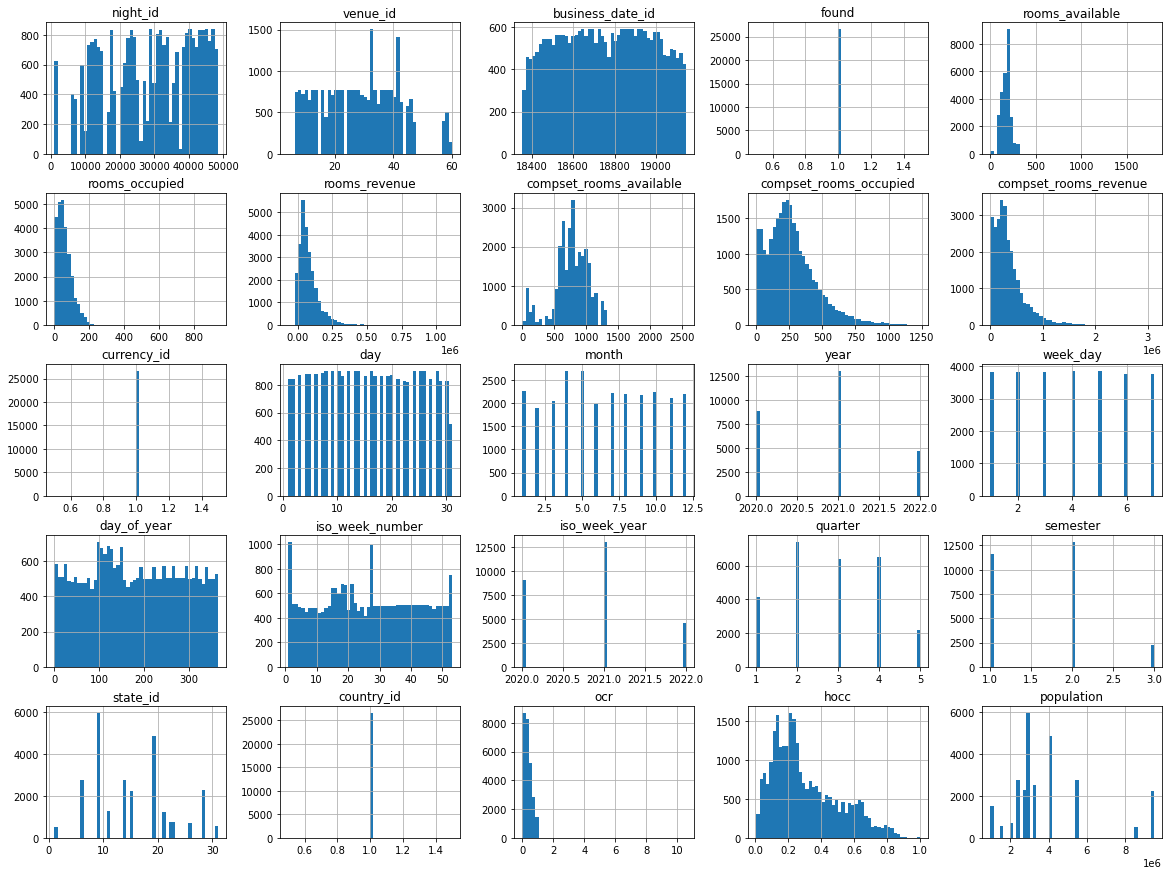

In [137]:
#Distribution of variables
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [14]:
df.shape

(26685, 32)

In [17]:
df.describe()

,night_id,venue_id,business_date_id,found,rooms_available,rooms_occupied,rooms_revenue,compset_rooms_available,compset_rooms_occupied,compset_rooms_revenue,...,day_of_year,iso_week_number,iso_week_year,quarter,semester,state_id,country_id,ocr,hocc,population
count,26685.000000,26685.000000,26685.000000,26685.0,26685.000000,26685.000000,2.668500e+04,26685.000000,26685.000000,2.668500e+04,...,26685.000000,26685.000000,26685.000000,26685.000000,26685.000000,26685.000000,26685.0,26500.000000,26685.000000,2.668500e+04
mean,28762.873150,28.147499,18751.691362,1.0,167.722241,58.507326,7.868654e+04,767.260371,267.051377,3.409242e+05,...,180.815252,26.599400,2020.834814,2.818999,1.648379,15.344950,1.0,0.364613,0.305094,3.850169e+06
std,12895.220834,12.893492,219.527333,0.0,51.950423,46.393136,7.700685e+04,265.967493,183.896155,2.879579e+05,...,104.432300,15.023069,0.695507,1.200637,0.626746,7.208025,0.0,0.283979,0.200314,2.149446e+06
min,974.000000,4.000000,18354.000000,1.0,0.000000,0.000000,-6.765100e+04,0.000000,0.000000,-3.266100e+03,...,0.000000,1.000000,2020.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.005400,9.526420e+05
25%,17818.000000,18.000000,18564.000000,1.0,127.000000,27.000000,2.995318e+04,614.000000,137.000000,1.462035e+05,...,96.000000,14.000000,2020.000000,2.000000,1.000000,9.000000,1.0,0.165829,0.147800,2.691472e+06
50%,29889.000000,29.000000,18752.000000,1.0,178.000000,51.000000,5.971041e+04,782.000000,240.000000,2.719098e+05,...,178.000000,26.000000,2021.000000,3.000000,2.000000,15.000000,1.0,0.320560,0.246300,2.842224e+06
75%,40445.000000,38.000000,18938.000000,1.0,198.000000,82.000000,1.064012e+05,950.000000,362.000000,4.509438e+05,...,271.000000,40.000000,2021.000000,4.000000,2.000000,19.000000,1.0,0.519481,0.435900,4.154139e+06
max,48510.000000,60.000000,19144.000000,1.0,1800.000000,940.000000,1.112671e+06,2557.000000,1237.000000,3.117600e+06,...,365.000000,53.000000,2022.000000,5.000000,3.000000,31.000000,1.0,10.555556,1.000000,9.501243e+06


In [91]:
df1.columns


Index(['rooms_available', 'rooms_occupied', 'rooms_revenue',
       'compset_rooms_available', 'compset_rooms_occupied',
       'compset_rooms_revenue', 'compset_rooms_revenue', 'hocc'],
      dtype='object')

In [161]:
df1=df.iloc[:,[4,5,6,7,8,9,28,29]]
df1.describe()

,rooms_available,rooms_occupied,rooms_revenue,compset_rooms_available,compset_rooms_occupied,compset_rooms_revenue,ocr,hocc
count,26685.000000,26685.000000,2.668500e+04,26685.000000,26685.000000,2.668500e+04,26500.000000,26685.000000
mean,167.722241,58.507326,7.868654e+04,767.260371,267.051377,3.409242e+05,0.364613,0.305094
std,51.950423,46.393136,7.700685e+04,265.967493,183.896155,2.879579e+05,0.283979,0.200314
min,0.000000,0.000000,-6.765100e+04,0.000000,0.000000,-3.266100e+03,0.000000,0.005400
25%,127.000000,27.000000,2.995318e+04,614.000000,137.000000,1.462035e+05,0.165829,0.147800
50%,178.000000,51.000000,5.971041e+04,782.000000,240.000000,2.719098e+05,0.320560,0.246300
75%,198.000000,82.000000,1.064012e+05,950.000000,362.000000,4.509438e+05,0.519481,0.435900
max,1800.000000,940.000000,1.112671e+06,2557.000000,1237.000000,3.117600e+06,10.555556,1.000000


In [162]:
df1.isnull().values.any()

True

In [165]:
df2=df1.dropna()

In [166]:
df2.isnull().values.any()

False

array([[<AxesSubplot:title={'center':'rooms_available'}>,
        <AxesSubplot:title={'center':'rooms_occupied'}>,
        <AxesSubplot:title={'center':'rooms_revenue'}>],
       [<AxesSubplot:title={'center':'compset_rooms_available'}>,
        <AxesSubplot:title={'center':'compset_rooms_occupied'}>,
        <AxesSubplot:title={'center':'compset_rooms_revenue'}>],
       [<AxesSubplot:title={'center':'ocr'}>,
        <AxesSubplot:title={'center':'hocc'}>, <AxesSubplot:>]],
      dtype=object)

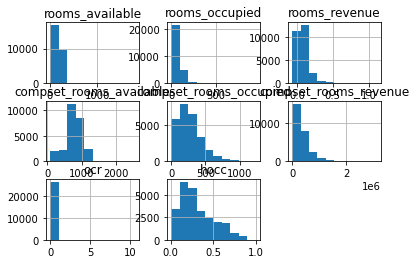

In [167]:
df2.hist()

Escalamos los datos

In [168]:
scaler = MinMaxScaler()

In [169]:
scale =scaler.fit_transform(df2)


In [171]:
df_scale = pd.DataFrame(scale, columns = df2.columns)
df_scale

,rooms_available,rooms_occupied,rooms_revenue,compset_rooms_available,compset_rooms_occupied,compset_rooms_revenue,ocr,hocc
0,0.082543,0.000000,0.057316,0.028317,0.000000,0.001047,0.000000,1.000000
1,0.103179,0.000000,0.057316,0.282767,0.046888,0.018323,0.000000,1.000000
2,0.082543,0.000000,0.057316,0.028317,0.000000,0.001047,0.000000,1.000000
3,0.103179,0.000000,0.057316,0.282767,0.071948,0.025798,0.000000,1.000000
4,0.082543,0.001064,0.060448,0.028317,0.000808,0.002231,0.000611,0.162075
...,...,...,...,...,...,...,...,...
26495,0.068042,0.044681,0.080449,0.205502,0.205335,0.054307,0.030845,0.003519
26496,0.145566,0.117021,0.167651,0.290453,0.285368,0.112705,0.038885,0.003519
26497,0.066927,0.076596,0.124510,0.216828,0.217462,0.094697,0.053709,0.001307
26498,0.068042,0.062766,0.092937,0.205502,0.238480,0.063593,0.043329,0.001307


Aplicamos PCA

In [172]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [173]:
pca = PCA()

In [174]:
pca.fit(df_scale)

PCA()

In [175]:
pca.explained_variance_

array([4.47479327e-02, 3.30916566e-02, 8.45005500e-03, 2.37154490e-03,
       1.26330990e-03, 5.22736301e-04, 1.37322808e-04, 5.68953657e-05])

In [176]:
pca.explained_variance_ratio_

array([0.49368066, 0.36508303, 0.09322506, 0.02616402, 0.01393744,
       0.00576708, 0.00151501, 0.0006277 ])

In [177]:
components = np.arange(pca.n_components_) + 1
variance = pca.explained_variance_ratio_

In [178]:
pca_summary_df = pd.DataFrame({"Proporción de la varianza": pca.explained_variance_ratio_, "Propoción acumulada":np.cumsum(pca.explained_variance_ratio_)})
pca_summary_df

,Proporción de la varianza,Propoción acumulada
0,0.493681,0.493681
1,0.365083,0.858764
2,0.093225,0.951989
3,0.026164,0.978153
4,0.013937,0.992090
5,0.005767,0.997857
6,0.001515,0.999372
7,0.000628,1.000000


In [179]:
pca_summary_df = pca_summary_df.transpose()
pca_summary_df

,0,1,2,3,4,5,6,7
Proporción de la varianza,0.493681,0.365083,0.093225,0.026164,0.013937,0.005767,0.001515,0.000628
Propoción acumulada,0.493681,0.858764,0.951989,0.978153,0.992090,0.997857,0.999372,1.000000


In [180]:
pca_summary_df.columns = ["PC" + str(pc) for pc in range(1, len(pca_summary_df.columns) + 1)]
pca_summary_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Proporción de la varianza,0.493681,0.365083,0.093225,0.026164,0.013937,0.005767,0.001515,0.000628
Propoción acumulada,0.493681,0.858764,0.951989,0.978153,0.992090,0.997857,0.999372,1.000000


In [181]:
pca_summary_df.columns = ["PC" + str(pc) for pc in range(1, len(pca_summary_df.columns) + 1)]
pca_summary_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Proporción de la varianza,0.493681,0.365083,0.093225,0.026164,0.013937,0.005767,0.001515,0.000628
Propoción acumulada,0.493681,0.858764,0.951989,0.978153,0.992090,0.997857,0.999372,1.000000


In [182]:
pca_components_df = pd.DataFrame(pca.components_.transpose(),
                                columns=components,
                                index=df1.columns)

In [185]:
pca_components_df

,1,2,3,4,5,6,7,8
rooms_available,0.006196,0.046868,0.130703,0.232761,0.025004,0.905296,0.128958,0.299480
rooms_occupied,0.130576,0.151499,-0.168661,0.187220,0.651127,0.061267,0.437809,-0.526405
rooms_revenue,0.153456,0.207027,-0.228850,0.733527,0.104879,-0.118539,-0.557729,0.083927
compset_rooms_available,0.112340,0.339654,0.902140,0.119172,0.107743,-0.179676,0.000794,-0.008026
compset_rooms_occupied,0.452369,0.597779,-0.190069,-0.534191,0.089321,0.154536,-0.287577,0.044454
compset_rooms_revenue,0.254063,0.376054,-0.153329,0.269033,-0.644804,-0.103232,0.517421,-0.063196
ocr,0.065623,0.060560,-0.130304,0.011447,0.358858,-0.309532,0.360827,0.787484
hocc,-0.820519,0.560537,-0.107826,-0.025238,0.016464,-0.001704,-0.003031,0.001010


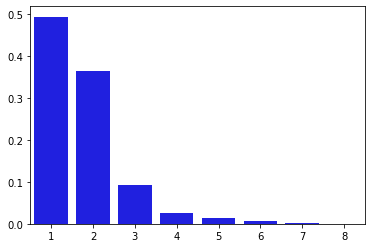

In [184]:
sns.barplot(x=components, y=variance, color="b")

plt.show()

Quitamos variables las cuales no tienen peso en el PCA

In [203]:
df_scale.head()

,rooms_available,rooms_occupied,rooms_revenue,compset_rooms_available,compset_rooms_occupied,compset_rooms_revenue,ocr,hocc
0,0.082543,0.000000,0.057316,0.028317,0.000000,0.001047,0.000000,1.000000
1,0.103179,0.000000,0.057316,0.282767,0.046888,0.018323,0.000000,1.000000
2,0.082543,0.000000,0.057316,0.028317,0.000000,0.001047,0.000000,1.000000
3,0.103179,0.000000,0.057316,0.282767,0.071948,0.025798,0.000000,1.000000
4,0.082543,0.001064,0.060448,0.028317,0.000808,0.002231,0.000611,0.162075


In [220]:
dfscale1=df_scale.iloc[:,[4,3,7]]
dfscale1

,compset_rooms_occupied,compset_rooms_available,hocc
0,0.000000,0.028317,1.000000
1,0.046888,0.282767,1.000000
2,0.000000,0.028317,1.000000
3,0.071948,0.282767,1.000000
4,0.000808,0.028317,0.162075
...,...,...,...
26495,0.205335,0.205502,0.003519
26496,0.285368,0.290453,0.003519
26497,0.217462,0.216828,0.001307
26498,0.238480,0.205502,0.001307


Volvemos a aplicar PCA

In [221]:
pca.fit(dfscale1)

PCA()

In [222]:
pca.explained_variance_

array([0.04204606, 0.02475791, 0.00714298])

In [223]:
pca.explained_variance_ratio_

array([0.56859765, 0.33480636, 0.09659599])

In [224]:
components = np.arange(pca.n_components_) + 1
variance = pca.explained_variance_ratio_

In [225]:
pca_summary_df = pd.DataFrame({"Proporción de la varianza": pca.explained_variance_ratio_, "Propoción acumulada":np.cumsum(pca.explained_variance_ratio_)})
pca_summary_df

,Proporción de la varianza,Propoción acumulada
0,0.568598,0.568598
1,0.334806,0.903404
2,0.096596,1.000000


In [226]:
pca_summary_df = pca_summary_df.transpose()
pca_summary_df

,0,1,2
Proporción de la varianza,0.568598,0.334806,0.096596
Propoción acumulada,0.568598,0.903404,1.000000


In [227]:
pca_summary_df.columns = ["PC" + str(pc) for pc in range(1, len(pca_summary_df.columns) + 1)]
pca_summary_df

,PC1,PC2,PC3
Proporción de la varianza,0.568598,0.334806,0.096596
Propoción acumulada,0.568598,0.903404,1.000000


In [228]:
pca_components_df = pd.DataFrame(pca.components_.transpose(),
                                columns=components,
                                index=dfscale1.columns)

In [229]:
pca_components_df 

,1,2,3
compset_rooms_occupied,-0.263400,0.840152,-0.474094
compset_rooms_available,-0.021020,0.486334,0.873520
hocc,0.964458,0.240051,-0.110440


<AxesSubplot:xlabel='hocc', ylabel='compset_rooms_occupied'>

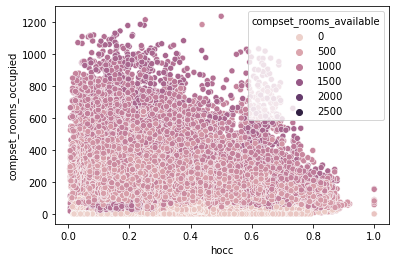

In [201]:
sns.scatterplot(x='hocc', y= 'compset_rooms_occupied' ,hue = 'compset_rooms_available',data=df1)

<AxesSubplot:xlabel='hocc', ylabel='compset_rooms_occupied'>

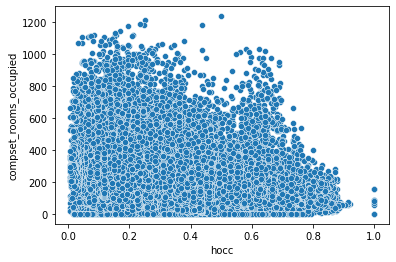

In [202]:
sns.scatterplot(x='hocc', y= 'compset_rooms_occupied' ,data=df1)

In [189]:
df2=df1.iloc[:, [4,7]]
df2.head()

,compset_rooms_occupied,hocc
0,0,1.0000
1,58,1.0000
2,0,1.0000
3,89,1.0000
4,1,0.1666


In [190]:
km.fit_predict(df2)

array([2, 2, 2, ..., 0, 0, 3])

In [191]:
km.cluster_centers_

array([[2.49713247e+02, 3.19451509e-01],
       [7.30513778e+02, 2.36471219e-01],
       [8.43503779e+01, 3.39476358e-01],
       [4.38340042e+02, 2.46439954e-01]])

In [192]:
df2["Clusters"] = km.labels_

C:\Users\vmhue\AppData\Local\Temp\ipykernel_8152\3055667265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Clusters"] = km.labels_


In [193]:
df2.columns

Index(['compset_rooms_occupied', 'hocc', 'Clusters'], dtype='object')

In [194]:
K =range (2,10)
inertias =[]
for i in K:
  kmeans =KMeans(n_clusters=i)
  kmeans.fit(df2)
  inertias. append(kmeans.inertia_)

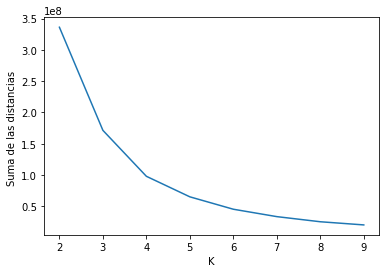

In [195]:
plt.plot(K, inertias)
plt.xlabel ("K")
plt.ylabel("Suma de las distancias ")
plt.show()

In [196]:
km = KMeans(n_clusters=4)

In [197]:
km.fit_predict(df2)

array([3, 3, 3, ..., 1, 1, 2])

In [198]:
km.cluster_centers_

array([[7.29360875e+02, 2.36488457e-01, 1.00729040e+00],
       [2.48490378e+02, 3.20019690e-01, 2.29822161e-02],
       [4.37498255e+02, 2.46302390e-01, 2.98377530e+00],
       [8.31096859e+01, 3.39409962e-01, 2.00000000e+00]])

In [199]:
df2["Clusters"] = km.labels_

C:\Users\vmhue\AppData\Local\Temp\ipykernel_8152\3055667265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Clusters"] = km.labels_


<AxesSubplot:xlabel='compset_rooms_occupied', ylabel='hocc'>

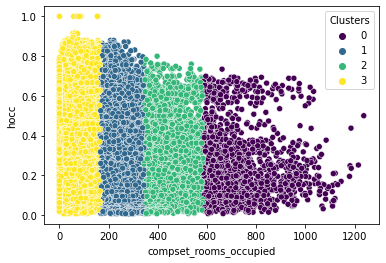

In [200]:
sns.scatterplot(x='compset_rooms_occupied', y= 'hocc',hue= 'Clusters',data=df2,palette="viridis",)

Podemos ver gracias a los clusters que la ocupacion hotelera afecta a los cuartos ocupados